In [1]:
# from sklearn import svm,metrics
# from sklearn.neighbors import KNeighborsClassifier # 분류
# from sklearn.neighbors import KNeighborsRegressor # 회귀-예측
from sklearn.linear_model import LinearRegression # 선형회귀
from sklearn.preprocessing import PolynomialFeatures # 다항특성을 만들어주는 라이브러리
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False # 마이너스 표시 해결
# 한글설정
matplotlib.rcParams['font.family'] = 'Malgun Gothic' # Windows 사용자
# matplotlib.rcParams['font.family'] = 'Apple Gothic' # Mac 사용자
matplotlib.rcParams['font.size'] = 10 # 글자크기

##### 데이터 피처 설명
- pclass : Passenger Class, 승객 등급
- survived : 생존 여부 : target 값이 됨.
- name : 승객 이름
- sex : 승객 성별
- age : 승객 나이
- sibsp : 탑승 한 형제/배우자 수
- parch : 탑승 한 부모/자녀 수
- ticket : 티켓 번호
- fare : 승객 지불 요금
- cabin : 선실 이름
- embarked : 승선항 (C = 쉘 부르그, Q = 퀸즈타운, S = 사우스 햄튼)
- body : 사망자 확인 번호 - 분석과정에서 제외해야 함. 머신러닝에 100% 영향을 미침.
- home.dest : 고향/목적지

In [2]:
# 타이타닉의 생존자 분류 모델을 구현하시오.
# target : survived
# data : 그외
# 데이터 확인 : nan,0, 타입,....
# 데이터 전처리 - nan,0,
# train,test세트
# 불필요한 피처를 제거 - 제거 피처는 체크 해 둘것
# 'name', 'ticket', 'body', 'cabin', 'home.dest' - name,cabin 사용 해 볼것.
# 각각 모델을 적용
# 정답률 체크
# 분류 : 로지스틱회귀, 결정트리, 랜덤포레스트
df_train = pd.read_csv('titanic_train.csv')
df_train.head(2)
df_test = pd.read_csv('titanic_test.csv')
df_train.head(2)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,body,home.dest
0,2,1,"Mellinger, Miss. Madeleine Violet",female,13.0,0,1,250644,19.5,NaN,S,NaN,"England / Bennington, VT"
1,2,1,"Wells, Miss. Joan",female,4.0,1,1,29103,23.0,NaN,S,NaN,"Cornwall / Akron, OH"


name,cabin의 데이터를 추가 

In [3]:
# 데이터 중에 ticket,body,home.dest를 제거
df_train = df_train.drop(['ticket','body','home.dest'],axis=1)

In [4]:
df_test = df_test.drop(['ticket','body','home.dest'],axis=1)

In [5]:
# 데이터 전처리 - 결측치
# df_train['embarked'].value_counts()
# age 데이터의 평균값으로 nan 데이터를 처리

# 결측치에 넣을 평균값 - train,test세트 모두 적용
replace_mean = df_train[df_train['age']>0]['age'].mean()
df_train['age'] = df_train['age'].fillna(replace_mean)
df_test['age'] = df_test['age'].fillna(replace_mean)

# embark : 결측값 - 데이터 2개
# 데이터중 가장 많이 나온 결과의 값을 대체
embarked_mode = df_train['embarked'].value_counts().index[0]
df_train['embarked'] = df_train['embarked'].fillna(embarked_mode)
df_test['embarked'] = df_test['embarked'].fillna(embarked_mode)

In [6]:
# train,test세트 합치기
whole_df = pd.concat([df_train,df_test])

In [7]:
train_idx_num = len(df_train)

In [8]:
# cabin 데이터 처리
# cabin: 선실 이름
whole_df['cabin'].value_counts().head()

cabin
C23 C25 C27        6
B57 B59 B63 B66    5
G6                 5
F4                 4
B96 B98            4
Name: count, dtype: int64

In [9]:
# 결측치 데이터를 X로 대체
whole_df['cabin'] = whole_df['cabin'].fillna('X')

In [10]:
# cabin의 데이터 앞 첫글자를 저장
whole_df['cabin'] = whole_df['cabin'].str[0]

In [11]:
whole_df['cabin'].value_counts()

cabin
X    1014
C      94
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: count, dtype: int64

In [12]:
# 항목중 데이터가 적은 수는 X로 대체
whole_df['cabin'] = whole_df['cabin'].replace({'G':'X','T':'X'})

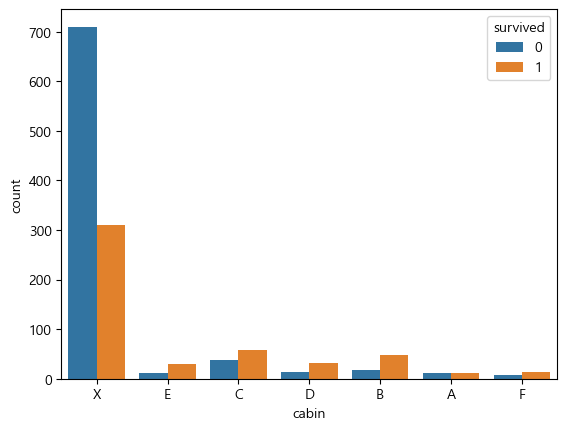

In [13]:
ax = sns.countplot(x='cabin',hue='survived',data=whole_df)

In [14]:
# name 피처 전처리
whole_df['name'].head()

0    Mellinger, Miss. Madeleine Violet
1                    Wells, Miss. Joan
2       Duran y More, Miss. Florentina
3                   Scanlan, Mr. James
4         Bradley, Miss. Bridget Delia
Name: name, dtype: object

In [15]:
# , 기준으로 분리해서 뒤에 부분을 저장
whole_df['name'] = whole_df['name'].str.split(',').str[1]

In [16]:
# . 기준으로 분리해서 앞에 부분을 저장
whole_df['name'] = whole_df['name'].str.split('.').str[0].str.strip()

In [17]:
whole_df['name'].unique()

array(['Miss', 'Mr', 'Master', 'Mrs', 'Dr', 'Mlle', 'Col', 'Rev', 'Ms',
       'Mme', 'Sir', 'the Countess', 'Dona', 'Jonkheer', 'Lady', 'Major',
       'Don', 'Capt'], dtype=object)

In [18]:
# 호칭에 따른 사회적 지위를 파악
grade_dict = {'A': ['Rev', 'Col', 'Major', 'Dr', 'Capt', 'Sir'], # 명예직을 나타냅니다.
              'B': ['Ms', 'Mme', 'Mrs', 'Dona'], # 여성을 나타냅니다.
              'C': ['Jonkheer', 'the Countess'], # 귀족이나 작위를 나타냅니다.
              'D': ['Mr', 'Don'], # 남성을 나타냅니다.
              'E': ['Master'], # 젊은남성을 나타냅니다.
              'F': ['Miss', 'Mlle', 'Lady']} # 젊은 여성을 나타냅니다.

In [19]:
# 함수를 적용해서 데이터 적용
def give_grade(x):
    for key,value in grade_dict.items():
        for title in value:
            if x == title:
                return key
        
    return 'G'
whole_df['name'] = whole_df['name'].apply(lambda x: give_grade(x))

In [20]:
whole_df['name']

0      F
1      F
2      F
3      D
4      F
      ..
388    D
389    B
390    D
391    D
392    F
Name: name, Length: 1309, dtype: object

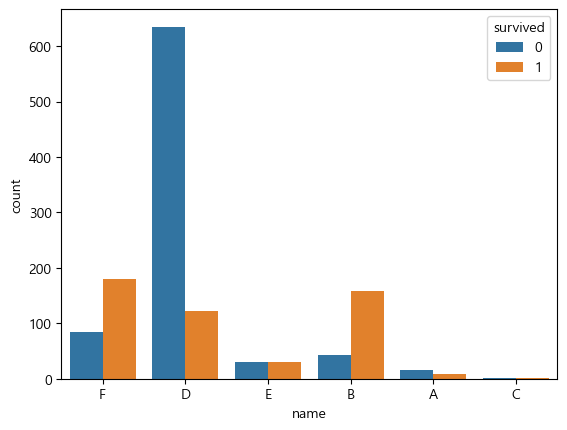

In [21]:
ax = sns.countplot(x='name',hue='survived',data=whole_df)

In [22]:
# 원핫인코딩
whole_df_encoded = pd.get_dummies(whole_df)
df_train2 = whole_df_encoded[:train_idx_num]
df_test2 = whole_df_encoded[train_idx_num:]

In [23]:
df_train2.head(2)

,pclass,survived,age,sibsp,parch,fare,name_A,name_B,name_C,name_D,...,cabin_A,cabin_B,cabin_C,cabin_D,cabin_E,cabin_F,cabin_X,embarked_C,embarked_Q,embarked_S
0,2,1,13.0,0,1,19.5,False,False,False,False,...,False,False,False,False,False,False,True,False,False,True
1,2,1,4.0,1,1,23.0,False,False,False,False,...,False,False,False,False,False,False,True,False,False,True


In [24]:
# train,test 세트 분리
# train: 916
train_input = whole_df_encoded.iloc[:train_idx_num,whole_df_encoded.columns != 'survived']
train_target = whole_df_encoded['survived'][:train_idx_num]

# target: 393
test_input = whole_df_encoded.iloc[train_idx_num:,whole_df_encoded.columns != 'survived']
test_target = whole_df_encoded['survived'][train_idx_num:]

In [25]:
# 표준화 작업
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(train_input)
train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

In [26]:
from sklearn.linear_model import LogisticRegression
# 데이터 훈련시키기
lr = LogisticRegression(random_state=42)
lr.fit(train_input,train_target)

c:\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [27]:
predict = lr.predict(test_input)

In [28]:
print(lr.score(train_input,train_target))
print(lr.score(test_input,test_target))

0.8155021834061136
0.7938931297709924


In [29]:
# 경사하강법
from sklearn.linear_model import SGDClassifier
sc = SGDClassifier(loss='log_loss',max_iter=10,random_state=42)
sc.fit(train_scaled,train_target)

c:\Python312\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:723: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


SGDClassifier(loss='log_loss', max_iter=10, random_state=42)

In [30]:
print(sc.score(train_scaled,train_target))
print(sc.score(test_scaled,test_target))

0.767467248908297
0.7506361323155216


In [31]:
classes = np.unique(train_target)
classes

array([0, 1], dtype=int64)

In [32]:
train_score = []
test_score = []
for _ in range(0,300):
    sc.partial_fit(train_scaled,train_target,classes=classes)
    train_score.append(sc.score(train_scaled,train_target))
    test_score.append(sc.score(test_scaled,test_target))

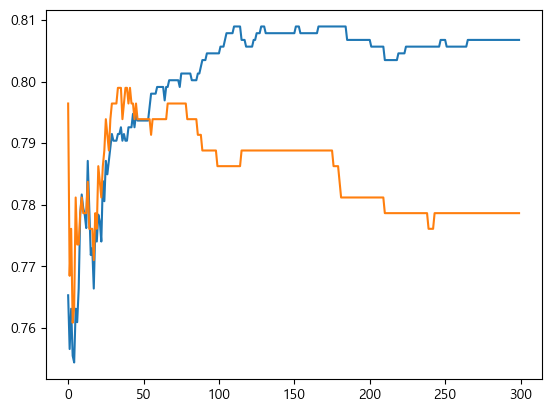

In [33]:
plt.plot(train_score)
plt.plot(test_score)

In [34]:
# 검증세트 - cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate

splitter = StratifiedKFold(n_splits=10,shuffle=True,random_state=42)
score = cross_validate(lr,train_scaled,train_target,cv=splitter)

In [35]:
np.mean(score['test_score'])

0.8067128523650263

In [43]:
# 랜덤 포레스트
from sklearn.ensemble import RandomForestClassifier
# n_jobs: core 전부 사용
rf = RandomForestClassifier(max_depth=5,n_jobs=-1,random_state=42)

scores = cross_validate(rf,train_input,train_target,return_train_score=True,n_jobs=-1)
print(np.mean(scores['train_score']),np.mean(scores['test_score']))

0.829417246289297 0.8133167023045855
